## `DeepONet` class

In the following code block, you can find a template for the class `DeepONet` that implements the DeepONet architecture from [1] (see project description). In particular, the architecture is of the form
$$
	{\rm DeepONet}(a,b,x,y) = \sum_{i=1}^{N} B_i (a,b) \, T_i (x,y),
$$
with the "Branch Net" $B (a,b)$ and the "Trunk Net" $T (x,y)$ being feedforward neural networks; $N$ is a hyper parameter, which is related to the complexity of the model. Therefore, the class `DeepONet` should rely on the previously implemented class `FeedforwardNeuralNetwork`.

#### (a)

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import random

class FeedforwardNeuralNetwork:

    def __init__(self, layer_sizes):
        """
        Initialize the feedforward neural network.
        
        Parameters:
        layer_sizes (list): List containing the number of neurons in each layer.
        """

        # Layer sizes include input and output layer sizes 
        self.layer_sizes = layer_sizes  
        self.num_layers = len(layer_sizes)
        
        # Initialize weights and biases with empty arrays
        # We use np.array instead of lists as later it will facilitate update operations
        self.weights = np.empty( (self.num_layers-1, ), dtype=object)
        self.biases = np.empty( (self.num_layers-2, ), dtype=object)
        
        # Loop through the hidden layers
        for l in range(1,self.num_layers-1):    
            
            # Initialize the weights with uniform distribution, as seen in the lecture notes
            self.weights[l-1] = np.random.uniform( -1/np.sqrt(layer_sizes[l]), +1/np.sqrt(layer_sizes[l]) ,size=(layer_sizes[l], layer_sizes[l-1]))

            # Initialize biases at zero
            self.biases[l-1] = np.zeros((layer_sizes[l],1))

        # Last weights (matrix A)
        self.weights[-1] = np.random.uniform( -1/np.sqrt(layer_sizes[-2]), +1/np.sqrt(layer_sizes[-2]), size=(layer_sizes[-1], layer_sizes[-2]))
        
    def activation(self, z):
        """
        Activation function.
        
        Parameters:
        z (numpy.ndarray): Input array.
        
        Returns:
        numpy.ndarray: Output array after applying the activation function.
        """
        # By default use ReLU activation. The activation function can be however replaced by 
        # assigning self.activation to a different function
        return z * (z > 0) # ReLU

    def activation_derivative(self, z):
        """
        Derivative of the activation function.
        
        Parameters:
        z (numpy.ndarray): Input array.
        
        Returns:
        numpy.ndarray: Output array after applying derivative of the activation function.
        """

        # Derivative of ReLU
        return 1. * (z > 0) 

    def feedforward(self, x):
        """
        Perform a feedforward pass through the network.
        
        Parameters:
        x (numpy.ndarray): Input array.
        
        Returns:
        numpy.ndarray: Output of the network.
        """

        # x is a single datapoint. Make sure it has the right dimensions and reshape to a column vector
        x = x.reshape((len(x), 1))

        # save activations of layers (a) for backpropagation
        self.a = [ x ]

        # save weighted inputs of layers (z) for backpropagation
        self.z = []       
        
        # Loop through the hidden layers
        for l in range(1,self.num_layers-1):

            # Compute and save z^(l) = W^(l)*a^(l-1) + b^(l)
            self.z.append( self.weights[l-1] @ self.a[-1] + self.biases[l-1] ) 

            # Compute and save a^(l) = activation(z^(l))
            self.a.append( self.activation(self.z[-1]))
            
        #Lastly, multiply by matrix A and return
        return self.weights[-1] @ self.a[-1]

    def compute_cost(self, y_pred, y_train):
        """
        Compute the cost function.
        
        Parameters:
        y_pred (numpy.ndarray): Predicted labels.
        y_train (numpy.ndarray): True labels.
        
        Returns:
        float: Cost value.
        """
        # At every epoch compute loss on the whole dataset
        # MSE Loss
        return ((y_pred - y_train)**2).sum()/y_pred.shape[0]
    
    def backpropagate(self, x, error,verbose=False):
        """
        Perform backpropagation to compute gradients.
        
        Parameters:
        x (numpy.ndarray): Input array.
        error (numpy.ndarray): Error array.
        
        Returns:
        tuple: Gradients of weights and biases.
        """

        # Compute the quantity d^(L) := dC/dz^(L)
        d = ( 2*error.transpose() @ self.weights[-1]) * self.activation_derivative(self.z[-1]).transpose()

        # Initialize the gradient arrays for weights and biases
        # Compute and add the gradients for the last layer
        nabla_w = [ d.transpose() @ self.a[-2].transpose()]
        nabla_b = [ d.transpose() ]

        # Loop through the hidden layers except for the last one, for which we have already computed the gradients
        for l in reversed(range(1,self.num_layers-2)):

            # Compute the quantity d^(l) := dMSE/dz^(l) using the recursive formula that involves d^(l+1)
            d = (d @ self.weights[l - 1 + 1]) * self.activation_derivative(self.z[l-1]).transpose()

            # Compute gradients for the current layer and save to array
            nabla_w.insert(0, d.transpose() @ self.a[l-1].transpose()) 
            nabla_b.insert(0, d.transpose())

        # Compute the gradient of the matrix A
        nabla_w.append( 2*error @ self.a[-1].transpose())  

        # Transform the lists into numpy arrays, as later it will facilitate update operations
        grads_w = np.empty( (len(nabla_w),), dtype=object)
        grads_b = np.empty( (len(nabla_b),), dtype=object)
        grads_w[...] = nabla_w
        grads_b[...] = nabla_b

        # return gradients arrays
        return (grads_w, grads_b)
     
    def update_parameters(self, nabla_w, nabla_b, learning_rate, beta, zeta):
        """
        Update the weights and biases using the computed gradients.
        
        Parameters:
        nabla_w (np.ndarray (dtype=object)): Gradients of weights.
        nabla_b (np.ndarray (dtype=object)): Gradients of biases.
        learning_rate (float): Learning rate.
        beta (float): Beta parameter (ADAM)
        zeta (float): Zeta parameter (ADAM)
        """
 
        # Implementation of ADAM, as explained in the lecture notes

        # Update u vectors 
        self.u_w = zeta*self.u_w + (1-zeta)*(nabla_w**2)
        self.u_b = zeta*self.u_b + (1-zeta)*(nabla_b**2)

        # Update v vectors 
        self.v_w = beta*self.v_w + (1 - beta)*nabla_w
        self.v_b = beta*self.v_b+ (1 - beta)*nabla_b

        # Compute alpha^(k)
        alpha = learning_rate*np.sqrt(1 - zeta**(self.k+1))/(1 - beta**(self.k+1))

        # Update weights and biases
        self.weights -= (alpha/( (self.u_w + 10**(-7))**0.5 ))*nabla_w
        self.biases -= (alpha/( (self.u_b + 10**(-7))**0.5 ))*nabla_b

        # Update iteration index
        self.k += 1

    def train(self, x_train, y_train, epochs, learning_rate, batch_size,adam_params=(0.9,0.999),verbose=False):
        """
        Train the neural network using mini-batch gradient descent with early stopping.
        
        Parameters:
        x_train (numpy.ndarray): Training data.
        y_train (numpy.ndarray): Training labels.
        epochs (int): Number of epochs.
        learning_rate (float): Learning rate.
        batch_size (int): Size of each mini-batch.
        """

        # Randomly shuffle indices of datapoints
        indices = list(range(len(y_train)))
        random.shuffle(indices)

        # Create batches using shuffled indices
        batches = [
            (x_train[i:i + batch_size], y_train[i:i + batch_size]) 
            for i in range(0, len(indices), batch_size)
        ]

        # Initialize ADAM parameters
        self.k = 0
        self.u_w = np.zeros( (len(self.weights), ), dtype=object)
        self.u_b = np.zeros( (len(self.biases), ), dtype=object) 
        self.v_w = np.zeros( (len(self.weights), ), dtype=object)
        self.v_b = np.zeros( (len(self.biases), ), dtype=object)

        # Initialize losses vector
        losses = []

        # Iterate through epochs
        # One epoch is defined as the number of steps until all training data has been used once
        for epoch in range(epochs):

            # Use all training data, perform one step for each batch
            for b in range(len(batches)):

                # Select the current batch
                x_batch, y_batch = batches[b%len(batches)]
            
                # Initialize grad variables
                nabla_w = np.zeros( (len(self.weights),), dtype=object)
                nabla_b = np.zeros( (len(self.biases),), dtype=object)

                # Iterate through the datapoints in the batch
                for i in range(len(x_batch)):
        
                    # Perform feedforward and compute error
                    error = self.feedforward(x_batch[i]) - y_batch[i]

                    # Perform backpropagation and compute partial gradients 
                    p_nabla_w, p_nabla_b = self.backpropagate(x_batch[i], error)

                    # Add partial gradients to final gradients. The resulting
                    # gradients nabla_w, nabla_b are the gradients of the MSE 
                    # loss of the batch
                    nabla_w += p_nabla_w/float(x_batch.shape[0])
                    nabla_b += p_nabla_b/float(x_batch.shape[0])
            
                #Update parameters
                self.update_parameters(nabla_w,nabla_b,learning_rate, adam_params[0], adam_params[1])

            #Make predictions on the whole dataset
            y_pred = np.zeros(y_train.shape)
            for i in range(len(x_train)):
                y_pred[i] = self.feedforward(x_train[i])

            # Compute loss on the whole dataset and print it
            cost = self.compute_cost(y_pred, y_train)
            losses.append(cost)

            if(verbose):
                print("Epoch: {}/{} |  Cost: {}".format(epoch,epochs,cost))

        return losses
                

In [121]:
class DeepONet:
    def __init__(self, branch_layer_sizes, trunk_layer_sizes):
        """
        Initialize the DeepONet architecture.
        
        Parameters:
        branch_layer_sizes (list): List containing the number of neurons in each layer for the branch net.
        trunk_layer_sizes (list): List containing the number of neurons in each layer for the trunk net.
        """
        self.branch_net = FeedforwardNeuralNetwork(branch_layer_sizes)
        self.trunk_net = FeedforwardNeuralNetwork(trunk_layer_sizes)

        sigmoid = lambda z : 1/(1 + np.exp(-z))
        sigmoid_prime = lambda z : sigmoid(z)*(1-sigmoid(z))

        relu = lambda z : z * (z > 0)
        relu_prime = lambda z : 1. * (z > 0)

        tanh = lambda z : np.tanh(z)
        tanh_prime = lambda z : 1 - np.tanh(z)**2

        self.branch_net.activation = relu
        self.branch_net.activation_derivative = relu_prime

        self.trunk_net.activation = relu
        self.trunk_net.activation_derivative = relu_prime     
        
        # Ensure the output dimensions of the branch and trunk nets match
        assert branch_layer_sizes[-1] == trunk_layer_sizes[-1], "Output dimensions of branch and trunk nets must match"

    def feedforward(self, x_branch, x_trunk):
        """
        Perform a feedforward pass through the DeepONet.
        
        Parameters:
        x_branch (numpy.ndarray): Input array for the branch net.
        x_trunk (numpy.ndarray): Input array for the trunk net.
        
        Returns:
        numpy.ndarray: Output of the DeepONet.
        """
        
        # Insert missing code!

        return (self.branch_net.feedforward(x_branch)*self.trunk_net.feedforward(x_trunk) ).sum()

    def compute_cost(self, y_pred, y_train):
        """
        Compute the cost function.
        
        Parameters:
        y_pred (numpy.ndarray): Predicted labels.
        y_train (numpy.ndarray): True labels.
        
        Returns:
        float: Cost value.
        """
        
        # Insert missing code!

        # Use MSE Loss
        return ((y_pred - y_train)**2).sum()/y_pred.shape[0]

    def backpropagate(self, x_branch, x_trunk, y):
        """
        Perform backpropagation to compute gradients.
        
        Parameters:
        x_branch (numpy.ndarray): Input array for the branch net.
        x_trunk (numpy.ndarray): Input array for the trunk net.
        y (numpy.ndarray): True labels.
        
        Returns:
        tuple: Gradients of weights and biases for both branch and trunk nets.
        """
        
        # Insert missing code!

        T = self.trunk_net.feedforward(x_trunk)
        B = self.branch_net.feedforward(x_branch)
        error = (T*B).sum() - y

        nabla_w_branch, nabla_b_branch = self.branch_net.backpropagate(x_branch, error*T)
        nabla_w_trunk, nabla_b_trunk = self.trunk_net.backpropagate(x_trunk, error*B)

        return (nabla_w_branch, nabla_b_branch, nabla_w_trunk, nabla_b_trunk)
        
    def update_parameters(self, nabla_w_branch, nabla_b_branch, nabla_w_trunk, nabla_b_trunk, learning_rate, beta, zeta):
        """
        Update the weights and biases using the computed gradients.
        
        Parameters:
        nabla_w_branch (list): Gradients of weights for the branch net.
        nabla_b_branch (list): Gradients of biases for the branch net.
        nabla_w_trunk (list): Gradients of weights for the trunk net.
        nabla_b_trunk (list): Gradients of biases for the trunk net.
        learning_rate (float): Learning rate.
        """
        
        # Insert missing code!

        self.branch_net.update_parameters(nabla_w_branch, nabla_b_branch, learning_rate, beta, zeta)
        self.trunk_net.update_parameters(nabla_w_trunk, nabla_b_trunk, learning_rate, beta, zeta)

    def train(self, x_branch, x_trunk, y_train, epochs, learning_rate, batch_size,verbose=False, adam_params=(0.9,0.999)):
        """
        Train the DeepONet using mini-batch gradient descent optimization with early stopping.
        
        Parameters:
        x_branch (numpy.ndarray): Training data for the branch net.
        x_trunk (numpy.ndarray): Training data for the trunk net.
        y_train (numpy.ndarray): Training labels.
        epochs (int): Number of epochs.
        learning_rate (float): Learning rate.
        batch_size (int): Size of each mini-batch.
        """
        
        # Insert missing code!

        #Initialize ADAM parameters for branch net
        self.branch_net.k = 0
        self.branch_net.u_w = np.zeros( (len(self.branch_net.weights), ), dtype=object)
        self.branch_net.u_b = np.zeros( (len(self.branch_net.biases), ), dtype=object) 
        self.branch_net.v_w = np.zeros( (len(self.branch_net.weights), ), dtype=object)
        self.branch_net.v_b = np.zeros( (len(self.branch_net.biases), ), dtype=object)

        #Initialize ADAM parameters for trunk net
        self.trunk_net.k = 0
        self.trunk_net.u_w = np.zeros( (len(self.trunk_net.weights), ), dtype=object)
        self.trunk_net.u_b = np.zeros( (len(self.trunk_net.biases), ), dtype=object) 
        self.trunk_net.v_w = np.zeros( (len(self.trunk_net.weights), ), dtype=object)
        self.trunk_net.v_b = np.zeros( (len(self.trunk_net.biases), ), dtype=object)

        # Shuffle indices
        indices = list(range(len(y_train)))
        random.shuffle(indices)

        # Create batches directly using shuffled indices
        batches = [
            (x_trunk[i:i + batch_size], x_branch[i:i + batch_size], y_train[i:i + batch_size]) 
            for i in range(0, len(indices), batch_size)
        ]

        losses = []

        for epoch in range(epochs):

            for b in range(len(batches)):

                # Select current batch
                x_batch_branch, x_batch_trunk, y_batch = batches[b]

                # Initialize grad variables
                nabla_w_branch = np.zeros( (len(self.branch_net.weights),), dtype=object)
                nabla_b_branch = np.zeros( (len(self.branch_net.biases),), dtype=object)
                nabla_w_trunk = np.zeros( (len(self.trunk_net.weights),), dtype=object)
                nabla_b_trunk = np.zeros( (len(self.trunk_net.biases),), dtype=object)

                for i in range(len(x_batch_branch)):

                    p_nabla_w_branch, p_nabla_b_branch, p_nabla_w_trunk, p_nabla_b_trunk = self.backpropagate(x_batch_trunk[i], x_batch_branch[i], y_batch[i])

                    # Add partial gradients to final gradients
                    nabla_w_branch += p_nabla_w_branch/float(x_batch_branch.shape[0])
                    nabla_b_branch += p_nabla_b_branch/float(x_batch_branch.shape[0])
                    nabla_w_trunk += p_nabla_w_trunk/float(x_batch_branch.shape[0])
                    nabla_b_trunk += p_nabla_b_trunk/float(x_batch_branch.shape[0])

                # update parameters
                self.update_parameters(nabla_w_branch, nabla_b_branch, nabla_w_trunk, nabla_b_trunk,learning_rate, adam_params[0], adam_params[1])

            #Make predictions on the whole dataset, then compute cost and print it
            y_pred = np.zeros(y_train.shape)
            for i in range(len(x_trunk)):
                y_pred[i] = self.feedforward(x_branch[i], x_trunk[i])

            cost = self.compute_cost(y_pred, y_train)
            losses.append(cost)

            if(verbose):    
                print("Epoch: {}/{} |  Cost: {}".format(epoch,epochs,cost))

        return losses
            

Preliminary testing: fix $a=1$ and $b=0$

In [86]:
# Function to approximate: sin(pi * x) * sin(pi * y)
def target_function(a, b, x, y):
    return a*np.sin(np.pi * x) * np.sin(np.pi * y) + b

# Generate training data (1000 datapoints)
x_trunk = np.random.rand(1000, 2)  # Random samples in [0, 1]
x_branch = np.zeros((1000,2))
x_branch[:,0] += 1
y_train = target_function(1,0, x_trunk[:, 0], x_trunk[:, 1]).reshape(-1, 1)


In [124]:
deeponet = DeepONet([2,32,32,32,32,32],[2,32,32,32,32,32])

In [125]:
deeponet.train(x_branch, x_trunk, y_train,200,0.00005,7,verbose=True)

Epoch: 0/200 |  Cost: 0.0842862433339857
Epoch: 1/200 |  Cost: 0.028971098428309933
Epoch: 2/200 |  Cost: 0.028010842109255567
Epoch: 3/200 |  Cost: 0.02653444006973023
Epoch: 4/200 |  Cost: 0.023610790153553385
Epoch: 5/200 |  Cost: 0.018216564963917617
Epoch: 6/200 |  Cost: 0.011021506697858455
Epoch: 7/200 |  Cost: 0.002512984279734797
Epoch: 8/200 |  Cost: 0.0005720972607905291
Epoch: 9/200 |  Cost: 0.00027867001899627326
Epoch: 10/200 |  Cost: 0.0001688494071296387
Epoch: 11/200 |  Cost: 0.00011587359563629682
Epoch: 12/200 |  Cost: 9.03798904267469e-05
Epoch: 13/200 |  Cost: 7.981906237509534e-05
Epoch: 14/200 |  Cost: 7.15107933152241e-05
Epoch: 15/200 |  Cost: 6.963571006263382e-05
Epoch: 16/200 |  Cost: 7.017840153855859e-05
Epoch: 17/200 |  Cost: 6.805147973641967e-05
Epoch: 18/200 |  Cost: 6.985330218971791e-05
Epoch: 19/200 |  Cost: 7.324823069039448e-05
Epoch: 20/200 |  Cost: 7.778411195000741e-05
Epoch: 21/200 |  Cost: 7.402981275092028e-05
Epoch: 22/200 |  Cost: 7.281618

KeyboardInterrupt: 

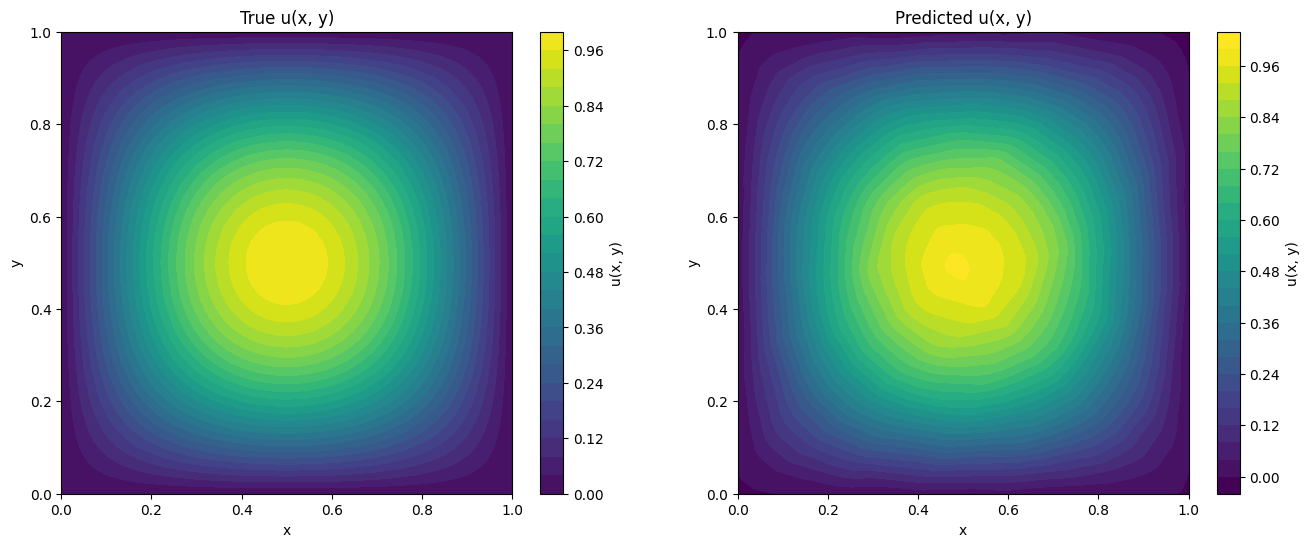

In [128]:
# 100 x 100 test grid
testsize = 100

# Coordinates of the gridpoints
y_coords = x_coords = np.linspace(0, 1, testsize)

# Test_dataset
x_test = np.array([[x, y] for x in x_coords for y in y_coords])
y_test = target_function(1,0,x_test[:,0], x_test[:,1])
x_test_branch = np.zeros(x_test.shape); x_test_branch[:,0] += 1
# Reshape as a grid
y_test_grid = y_test.reshape(testsize, testsize)


X, Y = np.meshgrid(x_coords, y_coords)

ypred = np.zeros(y_test.shape)
for i in range(len(ypred)):
    ypred[i] = deeponet.feedforward(x_test_branch[i],x_test[i])

ypred_grid = ypred.reshape(testsize, testsize)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# True u(x, y) values
c1 = axes[0].contourf(X, Y, y_test_grid, cmap="viridis", levels=30)
fig.colorbar(c1, ax=axes[0], label="u(x, y)")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[0].set_title("True u(x, y)")

# Predicted u(x, y) values
c2 = axes[1].contourf(X, Y, ypred_grid, cmap="viridis", levels=30)
fig.colorbar(c2, ax=axes[1], label="u(x, y)")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")
axes[1].set_title("Predicted u(x, y)")

# Ensure both plots share the same color scale
c1.set_clim(vmin=min(y_test.min(), ypred.min()), vmax=max(y_test.max(), ypred.max()))
c2.set_clim(vmin=min(y_test.min(), ypred.min()), vmax=max(y_test.max(), ypred.max()))

 #### (b)

Fix $b = 0$ and let $a \in [-1,1]$

In [215]:
n_samples = 10000

# Create dataset
x_branch = np.zeros((n_samples,2))
x_branch[:,0] = np.random.uniform(-1,1,(n_samples,))

x_trunk = np.random.uniform(0,1,(n_samples,2))

y_train = target_function(x_branch[:,0], 0, x_trunk[:,0], x_trunk[:,1]).reshape(-1,1)

#Normalize parameter a
x_branch[:,0] = (x_branch[:,0] + 1)/2

In [130]:
deeponet = DeepONet([2,32,32,32,32],[2,32,32,32,32])

In [131]:
losses = deeponet.train(x_branch, x_trunk, y_train, 50,0.00005,7, verbose=True)

Epoch: 0/50 |  Cost: 0.049505682013583865
Epoch: 1/50 |  Cost: 0.029126875943213174
Epoch: 2/50 |  Cost: 0.02857886494934022
Epoch: 3/50 |  Cost: 0.02791549340719949
Epoch: 4/50 |  Cost: 0.026915909030438865
Epoch: 5/50 |  Cost: 0.02528805787315616
Epoch: 6/50 |  Cost: 0.02267628027595482
Epoch: 7/50 |  Cost: 0.018782059302801465
Epoch: 8/50 |  Cost: 0.013831544140964947
Epoch: 9/50 |  Cost: 0.007955643182690576
Epoch: 10/50 |  Cost: 0.002147377040792839
Epoch: 11/50 |  Cost: 0.0007880416539652171
Epoch: 12/50 |  Cost: 0.00048819270419217975
Epoch: 13/50 |  Cost: 0.00035821928088484523
Epoch: 14/50 |  Cost: 0.00027801989724435364
Epoch: 15/50 |  Cost: 0.00023268367727539668
Epoch: 16/50 |  Cost: 0.00020016463175141118
Epoch: 17/50 |  Cost: 0.00018008840957280597
Epoch: 18/50 |  Cost: 0.00016733069331962297
Epoch: 19/50 |  Cost: 0.00015655681709385422
Epoch: 20/50 |  Cost: 0.00014903322094482192
Epoch: 21/50 |  Cost: 0.0001424649025910424
Epoch: 22/50 |  Cost: 0.00013672075658946022
Epo

From the above test training we can see that with the right selection of hyperparameters, the training loss reaches a very low value even after a low number of iterations. We therefore initially perform a coarse grid search, varying the architectures of the networks and their activation functions, while keeping the epochs at a low number (50) and fixing the learning rate, batch size and ADAM parameters. We use the optimal values found in the previous exercise.

In [132]:
# Create cross validation dataset
k_samples = 5000

x_branch_cv = np.zeros((k_samples,2))
x_branch_cv[:,0] = np.random.uniform(-1,1,(k_samples,))

x_trunk_cv = np.random.uniform(0,1,(k_samples,2))

y_cv = target_function(x_branch_cv[:,0], 0, x_trunk_cv[:,0], x_trunk_cv[:,1]).reshape(-1, 1)

#Normalize parameter a
x_branch_cv[:,0] = (x_branch_cv[:,0] + 1)/2



**Activation Functions**

In [115]:
# Functions
ReLu = lambda z : z * (z > 0)
ReLu_prime = lambda z : 1.* (z > 0)

tan_h = lambda z : (np.exp (2*z) - 1) / (np.exp (2*z) + 1)
tan_h_prime = lambda z : 1 - tan_h(z)**2

sigmoid = lambda z : 1/(1+np.exp(-z))
sigmoid_prime = lambda z : 1 / (1 + np.exp (z))

activation_function = [ReLu, tan_h, sigmoid]
derivative_activation_function = [ReLu_prime, tan_h_prime, sigmoid_prime]


labels_func = ['ReLu', 'tanh', 'sigmoid'] # Labels to keep track in cross-validation

**Neural Network Architecture**

We select three different types of architecture with different patterns, but with roughly the same number of parameters.

In [116]:
# Architectures         11008               9216                12352
architectures = [ [2, 128, 64, 32, 16], [2, 256, 32, 16], [2, 32, 64, 128, 16] ]

In [119]:
for act_b in range(len(activation_function)):

    for act_t in range(len(activation_function)):

        for arch_b in architectures:

            for arch_t in architectures:

                deeponet = DeepONet(arch_b, arch_t)

                deeponet.branch_net.activation = activation_function[act_b]
                deeponet.branch_net.activation_derivative = derivative_activation_function[act_b]

                deeponet.trunk_net.activation = activation_function[act_b]
                deeponet.trunk_net.activation_derivative = derivative_activation_function[act_b]

                deeponet.train(x_branch, x_trunk, y_train, 50, 0.00005,5)

                y_pred = np.zeros((k_samples,1))
                for j in range(k_samples):
                    y_pred[j] = deeponet.feedforward(x_branch_cv[j,:], x_trunk_cv[j,:])

                loss = deeponet.compute_cost(y_pred,y_cv)

                print("Arch branch: {} Arch trunk: {} Activation branch: {} Activation trunk: {} CV Loss: {}".format(arch_b, arch_t, labels_func[act_b], labels_func[act_t], loss))



Arch branch: [2, 128, 64, 32, 16] Arch trunk: [2, 128, 64, 32, 16] Activation branch: ReLu Activation trunk: ReLu CV Loss: 7.144106437387678e-05
Arch branch: [2, 128, 64, 32, 16] Arch trunk: [2, 256, 32, 16] Activation branch: ReLu Activation trunk: ReLu CV Loss: 7.095609684683555e-05
Arch branch: [2, 128, 64, 32, 16] Arch trunk: [2, 32, 64, 128, 16] Activation branch: ReLu Activation trunk: ReLu CV Loss: 3.3236827648594765e-05
Arch branch: [2, 256, 32, 16] Arch trunk: [2, 128, 64, 32, 16] Activation branch: ReLu Activation trunk: ReLu CV Loss: 8.30921003882148e-05
Arch branch: [2, 256, 32, 16] Arch trunk: [2, 256, 32, 16] Activation branch: ReLu Activation trunk: ReLu CV Loss: 6.470079302536495e-05
Arch branch: [2, 256, 32, 16] Arch trunk: [2, 32, 64, 128, 16] Activation branch: ReLu Activation trunk: ReLu CV Loss: 7.640554861201016e-05
Arch branch: [2, 32, 64, 128, 16] Arch trunk: [2, 128, 64, 32, 16] Activation branch: ReLu Activation trunk: ReLu CV Loss: 7.577736451773787e-05
Arch 

As seen from the grid search, the best combination of architectures and activation functions is 

- Branch architecture: [2, 32, 64, 128, 16]
- Trunk architecture: [2, 256, 32, 16]
- Branch activation function: ReLu
- Trunk activation function: Tanh

In [133]:
learning_rates = [0.0001, 0.00005, 0.00001]

In [134]:
batch_sizes = [ int(n_samples**(1/3)), int(n_samples**(2/3)), n_samples ]

In [138]:
betas = [0.9, 0.85]

In [139]:
zetas = [0.999, 0.95]

We choose to use 50 epochs because already with this number of epochs the loss is already low

In [141]:
import pickle

combinations = []

for lr in learning_rates:

    for bs in batch_sizes:

        for beta in betas:

            for zeta in zetas:

                deeponet = DeepONet([2, 32, 64, 128, 16], [2, 256, 32, 16])

                deeponet.trunk_net.activation = tan_h
                deeponet.trunk_net.activation_derivative = tan_h_prime

                deeponet.train(x_branch, x_trunk, y_train, 50, lr,bs,verbose=False,adam_params=(beta,zeta))

                y_pred = np.zeros((k_samples,1))
                for j in range(k_samples):
                    y_pred[j] = deeponet.feedforward(x_branch_cv[j,:], x_trunk_cv[j,:])

                loss = deeponet.compute_cost(y_pred,y_cv)
                print(" Learning rate: {} Batch size: {} Beta: {} Zeta: {} Loss: {}".format(lr,bs,beta,zeta,loss))

                combinations.append( (lr, bs, beta, zeta, loss))


pickle.dump(combinations, open("combinations_deeponet.dat","wb"))  

 Learning rate: 0.0001 Batch size: 21 Beta: 0.9 Zeta: 0.999 Loss: 0.0003377146957874848
 Learning rate: 0.0001 Batch size: 21 Beta: 0.9 Zeta: 0.95 Loss: 0.00013948151699308173
 Learning rate: 0.0001 Batch size: 21 Beta: 0.85 Zeta: 0.999 Loss: 0.0003319070578308209
 Learning rate: 0.0001 Batch size: 21 Beta: 0.85 Zeta: 0.95 Loss: 0.00022630394142027352
 Learning rate: 0.0001 Batch size: 464 Beta: 0.9 Zeta: 0.999 Loss: 0.029093686338897647


KeyboardInterrupt: 

From this grid search we can conclude that the optimal parameters are: 

- Learning rate: 0.0001
- Batch size: 21
- $\beta$ : 0.85
- $\zeta$ : 0.999

Let's now test the model for unseen values of a

In [216]:
# Create test set
m_samples = 5000

x_branch_test = np.zeros((m_samples,2))
x_branch_test[:,0] = np.random.uniform(-1,1,(m_samples,))

x_trunk_test = np.random.uniform(0,1,(m_samples,2))

y_test = target_function(x_branch_test[:,0], 0, x_trunk_test[:,0], x_trunk_test[:,1]).reshape(-1, 1)

#Normalize parameter a
x_branch_test[:,0] = (x_branch_test[:,0] + 1)/2



In [217]:
deeponet = DeepONet([2, 32, 64, 128, 16], [2, 256, 32, 16])
losses = deeponet.train(x_branch, x_trunk, y_train, 50, 0.0001, 21, adam_params=(0.85,0.999),verbose=True)

Epoch: 0/50 |  Cost: 0.08311113013058659
Epoch: 1/50 |  Cost: 0.028838611542446005
Epoch: 2/50 |  Cost: 0.02759249058859222
Epoch: 3/50 |  Cost: 0.025804426136049892
Epoch: 4/50 |  Cost: 0.022681830080576074
Epoch: 5/50 |  Cost: 0.016840721814603016
Epoch: 6/50 |  Cost: 0.008963798173241451
Epoch: 7/50 |  Cost: 0.002186573304730636
Epoch: 8/50 |  Cost: 0.0008243186125759601
Epoch: 9/50 |  Cost: 0.0004799509254633695
Epoch: 10/50 |  Cost: 0.00030965446357614457
Epoch: 11/50 |  Cost: 0.0002160871967299839
Epoch: 12/50 |  Cost: 0.0001610493693670353
Epoch: 13/50 |  Cost: 0.00012749102387230022
Epoch: 14/50 |  Cost: 0.00010832310898545492
Epoch: 15/50 |  Cost: 9.351820016566785e-05
Epoch: 16/50 |  Cost: 7.985068354504697e-05
Epoch: 17/50 |  Cost: 7.158158222109256e-05
Epoch: 18/50 |  Cost: 6.685885869627247e-05
Epoch: 19/50 |  Cost: 6.389570823956764e-05
Epoch: 20/50 |  Cost: 6.085031382989748e-05
Epoch: 21/50 |  Cost: 5.876956608251415e-05
Epoch: 22/50 |  Cost: 5.759212069523637e-05
Epoch

In [218]:
y_pred = np.zeros((m_samples,1))
for j in range(m_samples):
    y_pred[j] = deeponet.feedforward(x_branch_test[j,:], x_trunk_test[j,:])

print("Test Loss: {} ".format(deeponet.compute_cost(y_pred,y_test)))

Test Loss: 3.015169119003997e-05 


#### (c)

We are going to follow the same procedure as in point (b), also varyng $b \in [-1,1]$

In [225]:
n_samples = 10000

# Create train dataset
x_branch = np.random.uniform(-1,1,(n_samples,2))
x_trunk = np.random.uniform(0,1,(n_samples,2))

y_train = target_function(x_branch[:,0], x_branch[:,1], x_trunk[:,0], x_trunk[:,1]).reshape(-1,1)

#Normalize parameter a and b
x_branch[:,0] = (x_branch[:,0] + 1)/2
x_branch[:,1] = (x_branch[:,1] + 1)/2

In [226]:
k_samples = 5000

# Create cross-validation dataset
x_branch_cv = np.random.uniform(-1,1,(k_samples,2))
x_trunk_cv = np.random.uniform(0,1,(k_samples,2))

y_cv = target_function(x_branch_cv[:,0], x_branch_cv[:,1], x_trunk_cv[:,0], x_trunk_cv[:,1]).reshape(-1,1)

#Normalize parameter a and b
x_branch_cv[:,0] = (x_branch_cv[:,0] + 1)/2
x_branch_cv[:,1] = (x_branch_cv[:,1] + 1)/2

Use multiprocessing to speed up computation

In [187]:
# different combinations of architectures and functions
combinations = []

for act_b in range(len(activation_function)):

    for act_t in range(len(activation_function)):

        for arch_b in architectures:

            for arch_t in architectures:

                combinations.append((act_b, act_t, arch_b, arch_t))

In [188]:
def compute_cv_loss(activation_branch, activation_trunk, arch_branch, arch_trunk):

    deeponet = DeepONet(arch_branch, arch_trunk)

    deeponet.branch_net.activation = activation_function[activation_branch]
    deeponet.branch_net.activation_derivative = derivative_activation_function[activation_branch]

    deeponet.trunk_net.activation = activation_function[activation_trunk]
    deeponet.trunk_net.activation_derivative = derivative_activation_function[activation_trunk]

    deeponet.train(x_branch, x_trunk, y_train, 50, 0.00005,5)

    y_pred = np.zeros((k_samples,1))
    for j in range(k_samples):
        y_pred[j] = deeponet.feedforward(x_branch_cv[j,:], x_trunk_cv[j,:])

    return deeponet.compute_cost(y_pred,y_cv)



In [189]:
def worker(comb):
    return compute_cv_loss(comb[0],comb[1], comb[2], comb[3])

In [190]:
from concurrent.futures import ProcessPoolExecutor
import os

# Run with multiple threads 
num_cores = os.cpu_count()

with ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = list(executor.map(worker, combinations))

Observing the results, we can see that the loss at index 3 has the lowest value. The same index can be used to see the corresponding combination.

In [195]:
results[3]
combinations[3]

(0, 0, [2, 256, 32, 16], [2, 128, 64, 32, 16])

From this grid search we can conclude that the best combination of architectures and activation functions is 

Branch network:

- Architecture: [2, 256, 32, 16]
- Activation: ReLU

Trunk network:

- Architecture: [2, 128, 64, 32, 16]
- Activation: ReLU

In [206]:
pickle.dump( (combinations,results), open("combinations_results_c_deeponet.dat","wb")) 

Let us now perform another grid search for the other parameters:

In [201]:

combinations_2 = []

for lr in learning_rates:

    for bs in batch_sizes:

        for beta in betas:

            for zeta in zetas:

                combinations_2.append( (lr, bs, beta, zeta))


In [202]:
def compute_cv_loss_2(lr, bs, beta, zeta):

    deeponet = DeepONet([2, 256, 32, 16],[2, 128, 64, 32, 16])
    deeponet.train(x_branch, x_trunk, y_train, 200, lr, bs,adam_params=(beta,zeta))

    y_pred = np.zeros((k_samples,1))
    for j in range(k_samples):
        y_pred[j] = deeponet.feedforward(x_branch_cv[j,:], x_trunk_cv[j,:])

    print("Combo done!")
    return deeponet.compute_cost(y_pred,y_cv)

In [204]:
def worker_2(comb):
    return compute_cv_loss_2(comb[0], comb[1], comb[2], comb[3])

In [205]:

num_cores = os.cpu_count()
print("Num cores: {}".format(num_cores))

with ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = list(executor.map(worker_2, combinations_2))

Num cores: 16
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!
Combo done!


In [210]:
results[0], combinations_2[0]

(np.float64(2.050042879357849e-05), (0.0001, 21, 0.9, 0.999))

In conclusion, the optimized model has the following hyperparameters:

Branch network:

- Architecture: [2, 256, 32, 16]
- Activation: ReLU

Trunk network:

- Architecture: [2, 128, 64, 32, 16]
- Activation: ReLU

- Learning rate; 0.0001
- Batch size: 21
- $\beta$ = 0.9
- $\zeta$ = 0.999



Let's now test the model with new unseen data

In [227]:
# Create test set
m_samples = 5000


x_branch_test = np.random.uniform(-1,1,(m_samples,2))

x_trunk_test = np.random.uniform(0,1,(m_samples,2))

y_test = target_function(x_branch_test[:,0], x_branch_test[:,1], x_trunk_test[:,0], x_trunk_test[:,1]).reshape(-1, 1)

#Normalize parameter a and b
x_branch_test = (x_branch_test + 1)/2



In [228]:
deeponet = DeepONet([2, 256, 32, 16], [2, 128, 64, 32,16])
losses = deeponet.train(x_branch, x_trunk, y_train, 50, 0.0001, 21, adam_params=(0.85,0.999),verbose=True)

Epoch: 0/50 |  Cost: 0.04259212457506461
Epoch: 1/50 |  Cost: 0.03303604451509947
Epoch: 2/50 |  Cost: 0.029310045121645204
Epoch: 3/50 |  Cost: 0.02828181833947223
Epoch: 4/50 |  Cost: 0.027683087035619332
Epoch: 5/50 |  Cost: 0.027197525882567197
Epoch: 6/50 |  Cost: 0.026733233527711297
Epoch: 7/50 |  Cost: 0.026317001940016668
Epoch: 8/50 |  Cost: 0.025937633902148018
Epoch: 9/50 |  Cost: 0.025598667468257272
Epoch: 10/50 |  Cost: 0.02531066911183461
Epoch: 11/50 |  Cost: 0.025045102409673253
Epoch: 12/50 |  Cost: 0.024798274467986353
Epoch: 13/50 |  Cost: 0.024542130244404558
Epoch: 14/50 |  Cost: 0.024216964813326986
Epoch: 15/50 |  Cost: 0.02374307512687994
Epoch: 16/50 |  Cost: 0.022898868380135797
Epoch: 17/50 |  Cost: 0.020859132226179633
Epoch: 18/50 |  Cost: 0.015798228007540546
Epoch: 19/50 |  Cost: 0.006230596779570239
Epoch: 20/50 |  Cost: 0.0009589140150906094
Epoch: 21/50 |  Cost: 0.0005109702873602413
Epoch: 22/50 |  Cost: 0.00036948911149200207
Epoch: 23/50 |  Cost: 

In [229]:
y_pred = np.zeros((m_samples,1))
for j in range(m_samples):
    y_pred[j] = deeponet.feedforward(x_branch_test[j,:], x_trunk_test[j,:])

print("Test Loss: {} ".format(deeponet.compute_cost(y_pred,y_test)))

Test Loss: 0.0002970545738821036 
